# Задача
Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. Для оценки использовать метрику MAPE 

В данном ноутбуке мы собрали в датасет все спарсенные файлы, провели разведывательный анализ данных, кодировку и получили готовый для обучения датасет.

В этом проекте использовали: Ноутбук, через который парсили https://www.kaggle.com/igorchernov/sf-dst-car-price-parser

Спарсенный датасет https://www.kaggle.com/igorchernov/input/data-car-sales/

Ноутбук, в котором провели EDA https://www.kaggle.com/igorchernov/sf-dst-car-price-eda

Ноутбук, в котором провели обучение https://www.kaggle.com/igorchernov/sf-dst-car-price-ml

# Загрузка и предподготовка данных

In [519]:
#Импорт библиотек

import os
import numpy as np 
import pandas as pd 
import pandas_profiling
from pandas import Series
from itertools import combinations
from scipy.stats import ttest_ind

import re
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif, f_classif

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [520]:
import warnings 
warnings.filterwarnings("ignore") 

In [521]:
#Импорт данных из соревнования

data_test = pd.read_csv(os.path.join(os.getcwd(),'input/test.csv'))
data_sample = pd.read_csv(os.path.join(os.getcwd(),'input/sample_submission.csv'))

#Импорт своих данных

data_train = pd.DataFrame()
for dirname, _, filenames in os.walk(os.path.join(os.getcwd(),'input/data_car_sales')):
    
    for filename in filenames:
        print(filename)
        try:
            df = pd.read_csv(os.path.join(dirname, filename), sep=';')        
            data_train = data_train.append(df, ignore_index = True)
        except Exception as exc:
            print('generated an exception: %s' % (exc))
            
print(len(data_train))

audi.csv
bmw.csv
chery.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 40, saw 3

citroen.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 7, saw 13

ford.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 4, saw 8

gaz.csv
geely.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 9, saw 7

haval.csv
generated an exception: Error tokenizing data. C error: Expected 6 fields in line 16, saw 8

honda.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 61, saw 3

hundai.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 8, saw 4

infiniti.csv
generated an exception: Error tokenizing data. C error: Expected 1 fields in line 67, saw 4

kia.csv
land_rover.csv
generated an exception: Error tokenizing data. C error: Expected 2 fields in line 16, saw 3

lexus.csv
generated an exception:

In [522]:
data_train

,datetime,parsing_unixtime,card,region,sellerName,sell_id,car_url,price,description,image,...,brand,model_name,model_name2,name,equipment_dict,public_date,nview,model_name_full,confDict,dealerName
0,2021-04-16 11:59:35.823737+03:00,1.618564e+09,Audi A6 III (C6),Москва,Дмитрий,№ 1102441188,https://auto.ru/cars/used/sale/audi/a6/1102441...,545 000 ₽,Автомобиль в хорошем состояний. Комплектация: ...,https://avatars.mds.yandex.net/get-autoru-vos/...,...,Audi,A6,III (C6),3.0 AT (218 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",14 апреля,911,Audi A6 III (C6),"{'category': 'cars', 'mark': 'AUDI', 'model': ...",NaN
1,2021-04-16 11:59:36.694825+03:00,1.618564e+09,Audi Q7 I (4L),Новосибирск,Частное лицо,№ 1102877415,https://auto.ru/cars/used/sale/audi/q7/1102877...,1 470 000 ₽,"Автомобиль в комплектации SLine, был в одной с...",https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,...,Audi,Q7,I (4L),4.1d AT (326 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",11 апреля,322,Audi Q7 I (4L),"{'category': 'cars', 'mark': 'AUDI', 'model': ...",NaN
2,2021-04-16 11:59:36.880843+03:00,1.618564e+09,Audi Q5 I (8R) Рестайлинг,Калининград,Частное лицо,№ 1103078155,https://auto.ru/cars/used/sale/audi/q5/1103078...,1 830 000 ₽,Машина в идеальном состоянииПолностью в родной...,https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,...,Audi,Q5,I (8R) Рестайлинг,2.0 AT (225 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",13 апреля,89,Audi Q5 I (8R) Рестайлинг,"{'category': 'cars', 'mark': 'AUDI', 'model': ...",NaN
3,2021-04-16 11:59:36.699825+03:00,1.618564e+09,Audi A6 allroad I (C5),Москва,kor4min.mihail,№ 1102504513,https://auto.ru/cars/used/sale/audi/allroad/11...,390 000 ₽,Запрет оплачен все чеки есть. Автомобиль в xор...,https://avatars.mds.yandex.net/get-autoru-vos/...,...,Audi,A6 allroad,I (C5),2.7 AT (250 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",15 апреля,296,Audi A6 allroad I (C5),"{'category': 'cars', 'mark': 'AUDI', 'model': ...",NaN
4,2021-04-16 11:59:35.711726+03:00,1.618564e+09,Audi A6 allroad II (C6) Рестайлинг,Зеленогорск,Частное лицо,№ 1103186036,https://auto.ru/cars/used/sale/audi/allroad/11...,990 000 ₽,Машинка в полном порядке! Никакого чип тюнинга...,https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,...,Audi,A6 allroad,II (C6) Рестайлинг,3.0d AT (239 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",14 апреля,345,Audi A6 allroad II (C6) Рестайлинг,"{'category': 'cars', 'mark': 'AUDI', 'model': ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201691,2021-04-16 06:42:59.866332+03:00,1.618545e+09,LADA (ВАЗ) Vesta I,Грозный,Авто,№ 1102916469,https://auto.ru/cars/used/sale/vaz/vesta/11029...,820 000 ₽,"Комфорт Винтер без пробега Есть обогрев руля, ...",https://avatars.mds.yandex.net/get-autoru-vos/...,...,LADA (ВАЗ),Vesta,I,1.6 MT (106 л.с.),"{'asciiCat': 'cars', 'category': 'cars', 'engi...",24 марта,112,LADA (ВАЗ) Vesta I,"{'category': 'cars', 'mark': 'VAZ', 'model': '...",NaN
201692,2021-04-16 06:42:56.101955+03:00,1.618545e+09,LADA (ВАЗ) Vesta I,Екатеринбург,Частное лицо,№ 1103113581,https://auto.ru/cars/used/sale/vaz/vesta/11031...,812 900 ₽,"Автомобиль приобретен в феврале 2021г., резина...",https://avatars.mds.yandex.net/get-autoru-vos/...,...,LADA (ВАЗ),Vesta,I,1.6 MT (106 л.с.),"{'asciiCat': 'cars', 'category': 'cars', 'engi...",10 апреля,93,LADA (ВАЗ) Vesta I,"{'category': 'cars', 'mark': 'VAZ', 'model': '...",NaN
201693,2021-04-16 06:42:49.143259+03:00,1.618545e+09,LADA (ВАЗ) Largus I,Ставрополь,Частное лицо,№ 1103048341,https://auto.ru/cars/used/sale/vaz/largus/1103...,835 000 ₽,"Кондиционер,ГБО пропан,туманки все стеклоподъё...",https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,...,LADA (ВАЗ),Largus,I,Cross 1.6 MT (106 л.с.),"{'asciiCat': 'cars', 'category': 'cars', 'engi...",14 апреля,44,LADA (ВАЗ) Largus I Cross,"{'category': 'cars', 'mark': 'VAZ', 'model': '...",NaN
201694,2021-04-16 06:42:54.639809+03:00,1

Удалим дубликаты и пустые строки из спарсенных данных

In [523]:
data_train = data_train.drop_duplicates(subset=['sell_id'])
data_train = data_train.dropna(how='all')
len(data_train)

150117

In [524]:
#посмотрим какие колонки из data_train есть в data_test

#создадим пустой список, в который добавим колонки data_train, присутствующие в data_test
in_test = []
#создадим пустой список, в который добавим колонки data_train, отсутствующие в data_test
not_in_test = []

for column in data_train.columns:
    if column in data_test.columns:
        in_test.append(column)
    else:
        not_in_test.append(column)

Посмотрим на колонки data_train, присутствующие в data_test

In [525]:
in_test

['parsing_unixtime',
 'sell_id',
 'car_url',
 'description',
 'image',
 'bodyType',
 'color',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'productionDate',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня',
 'brand',
 'model_name',
 'name',
 'equipment_dict']

Посмотрим на колонки data_train, отсутствующие в data_test¶

In [526]:
not_in_test

['datetime',
 'card',
 'region',
 'sellerName',
 'price',
 'engine',
 'card_type',
 'model_name2',
 'public_date',
 'nview',
 'model_name_full',
 'confDict',
 'dealerName']

Удалим из data_train колонки, отсутствующие в data_test, кроме price

In [527]:
columns_to_drop = not_in_test[:4] + not_in_test[5:]

In [528]:
data_train = data_train.drop(columns_to_drop, axis = 1)
data_train.head(3)

,parsing_unixtime,sell_id,car_url,price,description,image,bodyType,color,engineDisplacement,enginePower,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,brand,model_name,name,equipment_dict
0,1.618564e+09,№ 1102441188,https://auto.ru/cars/used/sale/audi/a6/1102441...,545 000 ₽,Автомобиль в хорошем состояний. Комплектация: ...,https://avatars.mds.yandex.net/get-autoru-vos/...,седан,чёрный,3.0 л,218 л.с.,...,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,A6,3.0 AT (218 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."
1,1.618564e+09,№ 1102877415,https://auto.ru/cars/used/sale/audi/q7/1102877...,1 470 000 ₽,"Автомобиль в комплектации SLine, был в одной с...",https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,внедорожник 5 дв.,чёрный,4.1 л,326 л.с.,...,2 владельца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,Q7,4.1d AT (326 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."
2,1.618564e+09,№ 1103078155,https://auto.ru/cars/used/sale/audi/q5/1103078...,1 830 000 ₽,Машина в идеальном состоянииПолностью в родной...,https://autoru.naydex.net/1VPv37h28/4b1e74OtTr...,внедорожник 5 дв.,красный,2.0 л,225 л.с.,...,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,Audi,Q5,2.0 AT (225 л.с.) 4WD,"{'asciiCat': 'cars', 'category': 'cars', 'engi..."


Перезапишем data_test с теми колонками, которые есть и в data_train, и в data_test

In [529]:
data_test = data_test[in_test]
data_test.head(3)

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,brand,model_name,name,equipment_dict
0,1603226273,1100575026,https://auto.ru/cars/used/sale/skoda/octavia/1...,"Все автомобили, представленные в продаже, прох...",https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,синий,1.2 LTR,105 N12,бензин,...,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,OCTAVIA,1.2 AMT (105 л.с.),"{""engine-proof"":true,""tinted-glass"":true,""airb..."
1,1603226277,1100549428,https://auto.ru/cars/used/sale/skoda/octavia/1...,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,лифтбек,чёрный,1.6 LTR,110 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,OCTAVIA,1.6 MT (110 л.с.),"{""cruise-control"":true,""asr"":true,""esp"":true,""..."
2,1603226280,1100658222,https://auto.ru/cars/used/sale/skoda/superb/11...,"Все автомобили, представленные в продаже, прох...",https://avatars.mds.yandex.net/get-autoru-vos/...,лифтбек,серый,1.8 LTR,152 N12,бензин,...,1 владелец,Оригинал,передний,Левый,Не требует ремонта,Растаможен,SKODA,SUPERB,DSG 1.8 AMT (152 л.с.),"{""cruise-control"":true,""tinted-glass"":true,""es..."


Подготовим итоговый датасет для EDA

In [530]:
#приведем целевую переменную к числовому типу
data_train['price'] = data_train.price.apply(lambda x: int("".join(filter(str.isdigit, x))))

#объединяем трейн и тест, для учета всех возможных значений. Помечаем где у нас трейн
data_train['sample_'] = 0
data_test['sample_'] = 1
data_full = pd.concat([data_test, data_train])
data_full = data_full.reset_index().drop(['index'], axis = 1)

#задаем порядок столбцов
data_full = data_full[['parsing_unixtime', 'sell_id', 'car_url', 'description',
       'image', 'bodyType', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'productionDate', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня',
       'equipment_dict', 'brand', 'model_name', 'name', 'sample_', 'price']]

Удаляем дубликаты по ссылкам

In [531]:
data_full = data_full.drop_duplicates(subset=['car_url'])
len(data_full)

183247

Проверим на дубликаты по ИД объявлениям. Для этого приведем их к одному виду int, т.к. формат в трейне и тесте отличается. 

In [532]:
data_full['sell_id'] = data_full.sell_id.apply(lambda x: int(str(x).replace('№ ','')))
data_full['sell_id'].value_counts()

1100086706    2
1094975488    1
1103119046    1
1101359992    1
1102936954    1
             ..
1102639752    1
1103202338    1
1099787686    1
1055208716    1
1103103999    1
Name: sell_id, Length: 183246, dtype: int64

Обнаружены дублирующиеся ИД, посмотрим чем отличаются

In [533]:
data_full[data_full['sell_id'] == 1100086706]

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name,sample_,price
20414,1.603292e+09,1100086706,https://auto.ru/cars/used/sale/toyota/corolla/...,"Надёжная машина. гидроусилитель руля, полный э...",https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,хэтчбек 5 дв.,чёрный,1.5 LTR,110 N12,бензин,...,полный,Правый,Не требует ремонта,Растаможен,"{""airbag-driver"":true,""aux"":true,""usb"":true,""s...",TOYOTA,COROLLA,Runx 1.5 AT (110 л.с.) 4WD,1,NaN
122056,1.618588e+09,1100086706,https://auto.ru/cars/used/sale/toyota/allex/11...,"Надёжная машина. гидроусилитель руля, полный э...",https://avatars.mds.yandex.net/get-autoru-vos/...,хэтчбек 5 дв.,чёрный,1.5 л,110 л.с.,Бензин,...,полный,Правый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Toyota,Allex,1.5 AT (110 л.с.) 4WD,0,350000.0


У объявлений разные ссылки с идентичными параметрами.

https://auto.ru/cars/used/sale/toyota/allex/1100086706-8d67a4c7/

https://auto.ru/cars/used/sale/toyota/corolla/1100086706-8d67a4c7/

Пройдя по ссылками убедились, что данные спарсены корректно, и на самом деле существует два идентичных объявления. Подобные объявления будем оставлять только в одном экземпляре.

In [534]:
data_full = data_full.drop_duplicates(subset=['sell_id'])
len(data_full)

183246

# Описание датасета

* parsing_unixtime - дата время парсинга 
* sell_id - идентификатор объявления
* car_url - ссылка на объявление
* description - описание, комментарий продавца
* image - фото автомобиля
* bodyType - кузов
* color - цвет
* engineDisplacement - объем двигателя
* enginePower - мощность двигателя
* fuelType - тип двигателя (Бензин, Дизель, Гибрид, электро, Газ, Бензин+Газ, Дизель+Газ, Гибрид+Газ
* mileage - пробег
* productionDate - год выпуска автомобиля
* vehicleTransmission - тип коробки передач (механическая, автоматическая, вариатор, роботизированная)
* Владельцы - число владельцев авто (1, 2, 3 и более)
* ПТС - оригинальность ПТС (Оригинал, Дубликат)
* Привод - тип привода (передний, полный, задний)
* Руль - размещение рулевого колеса (Левый, Правый)
* Состояние - указывает на необходимость ремонта (Не требует ремонта, Битый / не на ходу)
* Таможня - необходимость процедуры растаможивания
* equipment_dict - дополнительная информация об автомобиле
* brand - марка авто (lada (ваз), toyota, kia, nissan, hyundai, bmw, mercedes-benz, renault, ford,
            skoda, mitsubishi, audi, opel, mazda, honda, volkswagen, lexus, peugeot, volvo,
            land rover, infiniti, subaru, chery, suzuki, citroen, lifan, geely, porsche, газ, haval)
* model_name - название модели
* name - расширенные технические данные
* sample_ - принадлежность к тестовому датасету
* price - цена авто

# EDA
Подготовим списки для распределения признаков, которые будем использовать в обучении и посмотрим на признаки ближе

In [535]:
#распределяем признаки по типу: бинарные (признаки с 2мя уникальными значениями), категориальные (более 2х уникальных значений) и числовые 
bin_cols = [] 
cat_cols = [] 
num_cols = [] 

Выгрузим предварительный отчет в html

In [536]:
car_sales_report = pandas_profiling.ProfileReport(data_full)
car_sales_report.to_file("car_sales_report.html")

Summarize dataset:   0%|          | 0/39 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим содержание итогового датасета

In [537]:
display(data_full.info())
display(data_full.sample(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183246 entries, 0 to 184802
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   parsing_unixtime     183246 non-null  float64
 1   sell_id              183246 non-null  int64  
 2   car_url              183246 non-null  object 
 3   description          183221 non-null  object 
 4   image                183246 non-null  object 
 5   bodyType             183246 non-null  object 
 6   color                183246 non-null  object 
 7   engineDisplacement   183246 non-null  object 
 8   enginePower          183246 non-null  object 
 9   fuelType             183246 non-null  object 
 10  mileage              183246 non-null  object 
 11  productionDate       183246 non-null  int64  
 12  vehicleTransmission  183246 non-null  object 
 13  Владельцы            183246 non-null  object 
 14  ПТС                  183245 non-null  object 
 15  Привод           

None

,parsing_unixtime,sell_id,car_url,description,image,bodyType,color,engineDisplacement,enginePower,fuelType,...,Привод,Руль,Состояние,Таможня,equipment_dict,brand,model_name,name,sample_,price
41764,1.618567e+09,1102941930,https://auto.ru/cars/used/sale/bmw/x5/11029419...,Куплен мною в трэд-ин у официалов.Оригинал ПТС...,https://avatars.mds.yandex.net/get-autoru-vos/...,внедорожник 5 дв.,серебристый,3.0 л,231 л.с.,Бензин,...,полный,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",BMW,X5,3.0i 3.0 AT (231 л.с.) 4WD,0,970000.0
106647,1.618581e+09,1103117317,https://auto.ru/cars/used/sale/renault/fluence...,Двигатель масло не ест совсем сцепление грм ре...,https://autoru.naydex.net/2eAqE6879/f119151Km/...,седан,серый,1.6 л,106 л.с.,Бензин,...,передний,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",Renault,Fluence,1.6 MT (106 л.с.),0,360000.0
162663,1.618528e+09,1103071675,https://auto.ru/cars/used/sale/vaz/2170/110307...,Третий хозяин. Оригинальный ПТС. Машина на ход...,https://autoru.naydex.net/kbh266A18/e46817kp/P...,хэтчбек 5 дв.,серый,1.6 л,98 л.с.,"Бензин, газобаллонное оборудование",...,передний,Левый,Не требует ремонта,Растаможен,"{'asciiCat': 'cars', 'category': 'cars', 'engi...",LADA (ВАЗ),Priora,1.6 MT (98 л.с.),0,215000.0


## 0. parsing_unixtime - дата время парсинга
Преобразуем в удобный тип и посмотрим на распределение по датам

In [538]:
data_full['datetime'] = data_full['parsing_unixtime'].apply(lambda x: datetime.datetime.fromtimestamp(x))
data_full['datetime'].dt.date.value_counts()

2021-04-16    94545
2021-04-17    41705
2020-10-21    18785
2021-04-15    12310
2020-10-19     6441
2020-10-20     3935
2020-10-25     3497
2020-10-24     1310
2020-10-26      718
Name: datetime, dtype: int64

## 1. sell_id - идентификатор объявления
Из html отчета car_sales_report видим, данный признак уникален, пропусков не осталось. Признак является идентификатором объявления. Смысловой нагрузки не несет, для обучение не отбираем

## 2. car_url - ссылка на объявление
По html отчету car_sales_report видим аналогичную с sell_id картину. Признак не будем использовать в обучении.

## 3. description - описание, комментарий продавца
Из html отчета car_sales_report видим - есть пропуски, много уникальных значений. Попробуем сгенерировать 2 признака на основании этого:
1 бинарный - наличие описания, 2 числовой - количество символов в описании.

In [539]:
data_full['description_len'] = data_full.description.apply(lambda x: len(str(x)))
data_full['description_is'] = data_full['description'].isna()

num_cols.append('description_len')
bin_cols.append('description_is')

## 4. image - фото автомобиля
Из html отчета car_sales_report видим, что фото не уникальны, а это странно, т.к. продаются б/у автомобили, соответственно ожидаем, что фото будут индивидуальные. Посмотрим пару объявлений с одинаковыми фотографиями.

In [540]:
#получаем самые частые фотографии
count_photos = data_full.image.value_counts()
display(count_photos.head(3))

#получаем ссылки на объявления, использующие самую популярную фотографию
data_full[data_full.image == count_photos.head(1).index[0]].car_url.values

https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d713fe4380ce1d36fac8ab0eb/cattouch    1987
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cff8494a7777d305c7e86a528/cattouch     1656
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d67764509bb9c7d50686014ec/cattouch    1273
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/vaz/granta/1098176684-c4c703f3/',
       'https://auto.ru/cars/used/sale/vaz/granta/1087551428-45a09f04/',
       'https://auto.ru/cars/used/sale/vaz/granta/1085270934-4389353b/',
       ...,
       'https://auto.ru/cars/used/sale/vaz/granta/1093228226-7928499d/',
       'https://auto.ru/cars/used/sale/vaz/granta/1099372618-851cd8ba/',
       'https://auto.ru/cars/used/sale/vaz/granta/1091834102-5efbb717/'],
      dtype=object)

Самая частая фотография используется в 1987 объявлениях. Пройдя по нескольким ссылкам видим, что продавец не загрузил фотографию, и используется стандартное фото из каталога.

Проверим пару ссылок с уникальными фотографиями.

In [541]:
#получим уникальные фотографии
display(count_photos.sort_values().head(3))

#получим ссылки на объявления с этими фотографиями
data_full[data_full.image.isin(count_photos.sort_values().head(3).index)].car_url.values

https://avatars.mds.yandex.net/get-autoru-vos/4581701/52c3c60a67e0735b8c4890806ab35061/1200x900n                                                                                                                                                                                                                      1
https://avatars.mds.yandex.net/get-autoru-vos/4366239/9b0efef2f9e15209e923c78c9279e64f/1200x900n                                                                                                                                                                                                                      1
https://autoru.naydex.net/2eAqE6879/f119151Km/zpOzLzD9BQI6y-6MuPmZuGJM9NRxedgC_2EWOZv9XL45GJzxzaaX1XoCgsa0tcAeL0QBfZjalH5COwVxyjM6x5-K5j8t1BgzQ4bG8ZD0nO0_bIyNAGmkJhfMprlHUdw-yLBgdYTPlqUPF49vGIlZy35RMUX5D61_k4YMNKYuxyrG79ezPAEAeqJrp4h00cF01gV4jNkkpEaniO61QxV8lmgEgIXk2w6oF29jU83J6R-mAT3JhTN926NmSHwOMqvCxtPw    1
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/bmw/5er/1103101701-386625a2/',
       'https://auto.ru/cars/used/sale/nissan/qashqai/1103007081-45438b8c/',
       'https://auto.ru/cars/used/sale/skoda/rapid/1103138095-7239b6b7/'],
      dtype=object)

Действительно, уникальные фотографии являются реальными. Наверняка покупатель сразу хочет видеть в каком состоянии авто. Сгенерируем для этого новый признак "real_photo". 
Скорее всего ссылки из каталога должны быть в одном формате. Попробуем зацепиться за фразу "get-verba" в ссылке.
Проверим верна ли догадка на парочке фотографий в единственном экземпляре, для которых проставилось значение о том, что фото не реальное

In [542]:
#генерируем признак
data_full['real_photo'] = data_full.image.apply(lambda x: x.find('get-verba') == -1)

#получаем нереальные фотографии в единственном экземпляре
real_photos = data_full[data_full['real_photo'] == False].image.value_counts()
display(real_photos.sort_values().head(3))

#получаем ссылки на объявления
data_full[data_full.image.isin(real_photos.head(3).index)].car_url.values

https://avatars.mds.yandex.net/get-verba/216201/2a00000160980e3f88b33f88d1fed8e5a4e1/cattouch      1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d588669852eaf921d764b16ff/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d562cbcb94ed86deed7d6624c/cattouch      1
Name: image, dtype: int64

array(['https://auto.ru/cars/used/sale/vaz/2107/1099142982-d4d59e13/',
       'https://auto.ru/cars/used/sale/vaz/2107/1102455458-9d6dabd3/',
       'https://auto.ru/cars/used/sale/vaz/2107/1098897690-e2eb6a40/',
       ...,
       'https://auto.ru/cars/used/sale/vaz/granta/1093228226-7928499d/',
       'https://auto.ru/cars/used/sale/vaz/granta/1099372618-851cd8ba/',
       'https://auto.ru/cars/used/sale/vaz/granta/1091834102-5efbb717/'],
      dtype=object)

Догадка подтвердилась. Реальность фотографии определяется верно. Используем новый признак для обучения. Определим его как бинарный.

In [543]:
bin_cols.append('real_photo')

## 5. bodyType
Из html отчета car_sales_report видим, что данные заполнены полностью без пропусков, признак явно категориальный. Судя по распределению, некоторых видов не так много, и некоторые значения однотипные. Попробуем их немного сгруппировать в более общие типы. 

In [544]:
def get_bodyClass(bodyType):
    
    bodyClass = 'other'
    
    dict_bodyTypes = {'седан' : ['седан', 'седан-хардтоп', 'фастбек'],
                          'внедорожник' : ['внедорожник 5 дв.', 'внедорожник 3 дв.', 'внедорожник открытый'],
                          'хэтчбек': ['хэтчбек 5 дв.', 'хэтчбек 4 дв.', 'хэтчбек 3 дв.', 'лифтбек'],
                          'универсал': ['универсал 5 дв.'],
                          'вэн': ['микровэн', 'минивэн', 'компактвэн'],                      
                          'пикап': ['пикап полуторная кабина', 'пикап одинарная кабина', 'пикап двойная кабина', 'фургон'],
                          'кабрио': ['купе', 'купе-хардтоп', 'седан 2 дв.', 'кабриолет', 'фаэтон', 'тарга', 'родстер']
                     }
    
    for key, value in dict_bodyTypes.items():   
        if bodyType in value:
            bodyClass = key
            break
    
    return bodyClass

data_full['bodyClass'] = data_full.bodyType.apply(lambda x: get_bodyClass(x))
data_full.bodyClass.value_counts()

седан          74539
внедорожник    51925
хэтчбек        37149
универсал       9960
вэн             5078
кабрио          2963
пикап           1625
other              7
Name: bodyClass, dtype: int64

Удалось сократить с 26 до 8 типов кузовов. Данные распределились более равномерно, единичные экземпляры объединились в группу other. Признак отнесем к категориальным

In [545]:
cat_cols.append('bodyClass')

## 6. color - цвет
Из html отчета car_sales_report видим, что данный признак лучше отнести к категориальному. Значения заполнены хорошо, пропусков нет. Уникальных значений 16 без дублирующихся по смыслу. Оставим в таком виде и добавим в список категориальных

In [546]:
cat_cols.append('color')

## 7. engineDisplacement

- объём двигателя, л; тип данных - object

In [547]:
data_full.engineDisplacement.value_counts()

1.6 л      56408
2.0 л      22203
1.5 л      13638
3.0 л       9306
2.0 LTR     7391
           ...  
1.1 LTR        4
4.9 LTR        4
3.9 л          3
3.9 LTR        1
5.3 LTR        1
Name: engineDisplacement, Length: 108, dtype: int64

Проверим признак на пустые ячейки.

In [548]:
data_full.engineDisplacement.isna().sum()

0

Посмотрим все уникальные значения признака.

In [549]:
data_full.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '3.0 л ', '4.1 л ', '2.0 л ', '2.7 л ', '2.8 л ',
       '1.4 л ', '2.4 л ', '2.3 л ', '1.8 л ', '2.5 л ', '4.2 л ',
       '3.3 л ', '1.6 л ', '3.7 л ', '1.9 л ', '1.2 л ', '3.1 л ',
       '3.2 л ', '6.0 л ', '5.2 л ', '3.6 л ', '5.9 л ', '5.0 л ',
       '6.3 л ', '4.0 л ', '1.5 л ', '2.9 л ', '4.4 л ', '6.6 л ',
       '2.

Заменим значение ' LTR' на 0, так как здесь отсутствует ДВС.

In [550]:
data_full.engineDisplacement = data_full.engineDisplacement.apply(lambda x: '0.0' if x == ' LTR' else x)

Уберем из этого списка одно неподходящее для преобразования в число значение 'Hyundai Grand Starex I'.

In [551]:
data_full = data_full.drop(data_full[data_full.engineDisplacement == 'Hyundai Grand Starex I'].index)

Преобразуем признак из object в числовой.

In [552]:
pattern = re.compile('\d+\.\d+')

data_full['engineDisplacement'] = data_full['engineDisplacement'].apply(lambda x: float(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

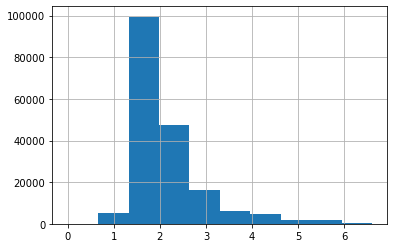

In [553]:
data_full['engineDisplacement'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [554]:
num_cols.append('engineDisplacement')

## 8. enginePower

- мощность двигателя, л. с.; тип данных - object

In [555]:
data_full.enginePower.value_counts()

 98 л.с.      7613
 81 л.с.      6760
 150 л.с.     6588
 106 л.с.     5877
 87 л.с.      5575
              ... 
 449 л.с.        1
 635 л.с.        1
303 N12          1
42 N12           1
402 N12          1
Name: enginePower, Length: 627, dtype: int64

Проверим признак на пустые ячейки.

In [556]:
data_full.enginePower.isna().sum()

0

Посмотрим все уникальные значения признака.

In [557]:
data_full.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

Преобразуем признак из object в числовой.

In [558]:
pattern = re.compile('\d+')

data_full['enginePower'] = data_full['enginePower'].apply(lambda x: float(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

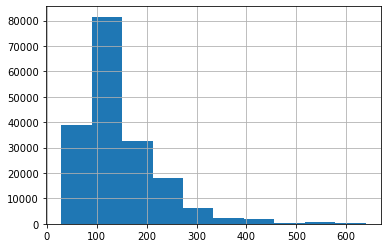

In [559]:
data_full['enginePower'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [560]:
num_cols.append('enginePower')

## 9. fuelType

- тип топлива; тип данных - object

In [561]:
data_full.fuelType.value_counts()

 Бензин                                129931
бензин                                  28601
 Дизель                                 14766
дизель                                   5800
 Бензин, газобаллонное оборудование      2738
 Гибрид                                  1077
гибрид                                    223
электро                                    55
 Газ, газобаллонное оборудование           24
 Газ                                       17
газ                                         7
 Дизель, газобаллонное оборудование         4
 Гибрид, газобаллонное оборудование         3
Name: fuelType, dtype: int64

Проверим признак на пустые ячейки.

In [562]:
data_full.fuelType.isna().sum()

0

Приведем все значения к нижнему регистру.

In [563]:
data_full.fuelType = data_full.fuelType.apply(lambda x: x.lower())

Посмотрим все уникальные значения.

In [564]:
data_full.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', ' бензин',
       ' дизель', ' бензин, газобаллонное оборудование', ' гибрид',
       ' дизель, газобаллонное оборудование', ' газ',
       ' газ, газобаллонное оборудование',
       ' гибрид, газобаллонное оборудование'], dtype=object)

Преобразуем ' Газ, газобаллонное оборудование' в ' Газ'.

In [565]:
data_full.fuelType = data_full.fuelType.apply(lambda x: 'газ' if x in [' газ, газобаллонное оборудование',
                                                                       ' бензин, газобаллонное оборудование',
                                                                       ' дизель, газобаллонное оборудование',
                                                                       ' гибрид, газобаллонное оборудование'] else x)

Удалим одну строку со значением '1618546594.0'.

In [566]:
data_full = data_full.drop(data_full[data_full.fuelType == '1618546594.0'].index)

Приведем уникальные значения к единообразному виду.

In [567]:
pattern = re.compile('[а-я]+')

data_full.fuelType = data_full.fuelType.apply(lambda x: 'гибрид' if len(x.split(',')) == 2 else pattern.findall(x)[0])

In [568]:
data_full.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

Объединим признаки гибрид и электро

In [569]:
data_full.fuelType = data_full.fuelType.apply(lambda x: 'электро' if x in ['электро', 'гибрид'] else x)

In [570]:
data_full.fuelType.value_counts()

бензин     158532
дизель      20566
газ          2793
электро      1355
Name: fuelType, dtype: int64

<AxesSubplot:>

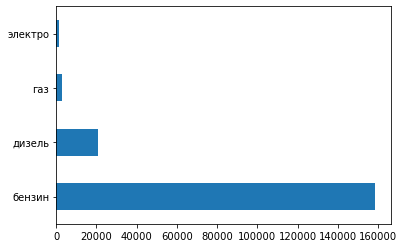

In [571]:
data_full.fuelType.value_counts().plot.barh()

В результате преобразований получен категориальный признак.

In [572]:
cat_cols.append('fuelType')

## 10. mileage

- пробег автомобиля, км; тип данных - object

In [573]:
data_full.mileage.value_counts()

200 000 км    2711
150 000 км    2439
180 000 км    1852
100 000 км    1703
120 000 км    1690
              ... 
79 313 км        1
125 415 км       1
173 233 км       1
150 082 км       1
139 798 км       1
Name: mileage, Length: 42528, dtype: int64

Проверим признак на пустые ячейки.

In [574]:
data_full.mileage.isna().sum()

0

In [575]:
data_full.mileage

0            74000
1            60563
2            88000
3            95000
4            58536
            ...   
184798        2 км
184799      570 км
184800    4 000 км
184801      100 км
184802        1 км
Name: mileage, Length: 183246, dtype: object

Посмотрим на структуру значений.

In [576]:
data_full.mileage[0]

74000

In [577]:
data_full.mileage[184802]

'1\xa0км'

Уберем части строки равные '\xa0' из всех значений признака.

In [578]:
data_full['mileage'] = data_full['mileage'].apply(lambda x: str(x).replace('\xa0', ''))

Преобразуем признак из object в числовой.

In [579]:
pattern = re.compile('\d+')

data_full['mileage'] = data_full['mileage'].apply(lambda x: int(pattern.findall(x)[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

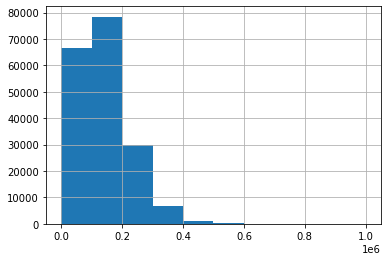

In [580]:
data_full['mileage'].hist()

В результате пребразований получен числовой признак. Распределение можно считать нормальным.

In [581]:
num_cols.append('mileage')

## 11. productionDate

- год производства автомобиля; тип данных - float

In [582]:
data_full.productionDate.value_counts()

2012    13639
2013    12892
2011    12456
2008    12043
2017    11692
        ...  
1974        1
1962        1
1968        1
1970        1
1904        1
Name: productionDate, Length: 73, dtype: int64

Проверим признак на пустые ячейки.

In [583]:
data_full.productionDate.isna().sum()

0

Посмотрим на уникальные значения.

In [584]:
data_full.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 2021, 1962, 1956, 1958], dtype=int64)

Преобразуем признак из object в числовой.

In [585]:
pattern = re.compile('\d+')

data_full['productionDate'] = data_full['productionDate'].apply(lambda x: int(pattern.findall(str(x))[0]))

Построим гистограмму распределения признака.

<AxesSubplot:>

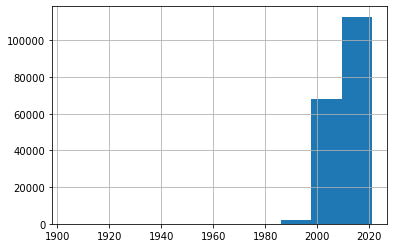

In [586]:
data_full['productionDate'].hist()

В результате пребразований получен числовой признак. На распределении визуально заметны выбросы, но они не противоречат здравому смыслу, поэтому их можно оставить.

In [587]:
num_cols.append('productionDate')

## Генерация дополнительных числовых признаков

Создание числового признака соотношения пробега к периоду пробега

In [588]:
data_full['feature_mileage'] = ((2022-data_full['productionDate'])*17.5)/data_full['mileage']

In [589]:
num_cols.append('feature_mileage')

Расчет транспортного налога и создание числового признака его значения

In [590]:
data_full['tax'] = data_full['enginePower'].apply(lambda x: x*12 if x < 100 else x*25 if x < 125 else x*35 
                                                                      if x < 150 else x*45 if x < 175 else x*50 if x < 200 else 
                                                                      x*65 if x < 225 else x*75 if x < 250 else x*150)

In [591]:
num_cols.append('tax')

## 12. vehicleTransmission

- тип трансмиссии автомобиля; тип данных - object

In [593]:
data_full.vehicleTransmission.value_counts()

механическая        80621
автоматическая      73248
вариатор            17586
роботизированная    11791
Name: vehicleTransmission, dtype: int64

Проверим признак на пустые ячейки.

In [594]:
data_full.productionDate.isna().sum()

0

<AxesSubplot:>

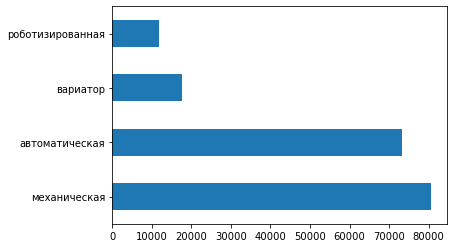

In [595]:
data_full['vehicleTransmission'].value_counts().plot.barh()

В данном признаке дополнительных преобразований не требуется. Признак является категориальным.

In [596]:
cat_cols.append('vehicleTransmission')

## 13. Владельцы

- количество владельцев автомобиля; тип данных - object

In [597]:
data_full['Владельцы'].value_counts()

3 или более    83322
1 владелец     53185
2 владельца    46739
Name: Владельцы, dtype: int64

Проверим признак на пустые ячейки.

In [598]:
data_full.productionDate.isna().sum()

0

Посмотрим на уникальные значения.

In [599]:
data_full['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

В данном столбце мы имеем категориальные значения. Преобразуем данные к презентабельному виду - заменим части строки равные '\xa0' на ' ' во всех значениях признака.

In [600]:
data_full['Владельцы'] = data_full['Владельцы'].apply(lambda x: str(x).replace('\xa0', ' '))

<AxesSubplot:>

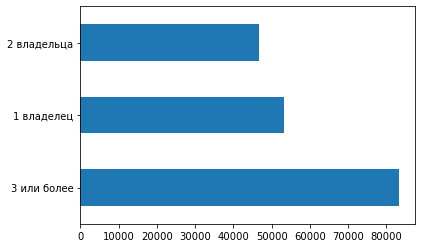

In [601]:
data_full['Владельцы'].value_counts().plot.barh()

In [602]:
cat_cols.append('Владельцы')

## 14. ПТС

- вид технического паспорта автомобиля; тип данных - object

В отчете html видим есть 1 пропуск, заполним его самым частым значением

In [603]:
data_full['ПТС'] = data_full['ПТС'].fillna(data_full['ПТС'].value_counts().head(1).index[0])

In [604]:
data_full['ПТС'].value_counts()

Оригинал    159915
Дубликат     23331
Name: ПТС, dtype: int64

<AxesSubplot:xlabel='ПТС', ylabel='count'>

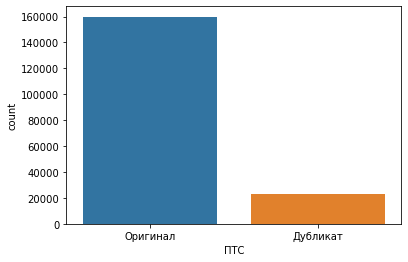

In [605]:
sns.countplot(x = 'ПТС', data = data_full)

Видно, что оригинальных ПТС намного больше, чем дубликатов.

Здесь мы имеем бинарный признак. Дополнительных преобразований не требуется.

In [606]:
bin_cols.append('ПТС')

## 15. Привод

- вид привода автомобиля, тип данных - object

In [607]:
data_full['Привод'].value_counts()

передний    108921
полный       55811
задний       18514
Name: Привод, dtype: int64

Проверим признак на ниличие пустых значений

In [608]:
data_full.Привод.isna().sum()

0

<AxesSubplot:xlabel='Привод', ylabel='count'>

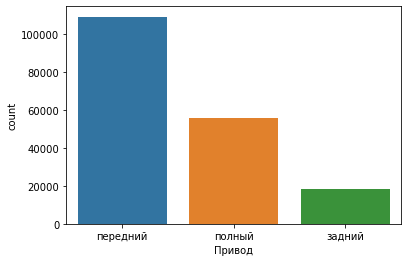

In [609]:
sns.countplot(x='Привод', data=data_full)

Признак категориальный. Дополнительная обработка не требуется

In [610]:
cat_cols.append('Привод')

## 16. Руль

расположение рулевого колеса; тип данных - object

In [611]:
data_full['Руль'].value_counts()

Левый     174678
Правый      8568
Name: Руль, dtype: int64

Проверим наличие пустых значений

In [612]:
data_full.Руль.isna().sum()

0

<AxesSubplot:xlabel='Руль', ylabel='count'>

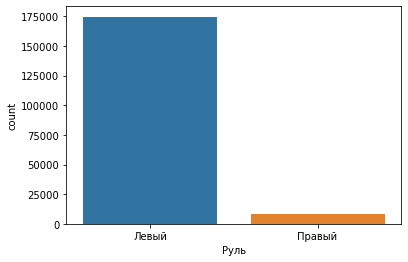

In [613]:
sns.countplot(x='Руль', data=data_full)

Признак бинарный. Дополнительная обработка не требуется

In [614]:
bin_cols.append('Руль')

## 17. Состояние

указатель необходимости ремонта автомобиля; тип данных - object

In [615]:
data_full['Состояние'].value_counts()

Не требует ремонта    183243
Битый / не на ходу         3
Name: Состояние, dtype: int64

Проверим наличие пустых значений

In [616]:
data_full.Состояние.isna().sum()

0

<AxesSubplot:xlabel='Состояние', ylabel='count'>

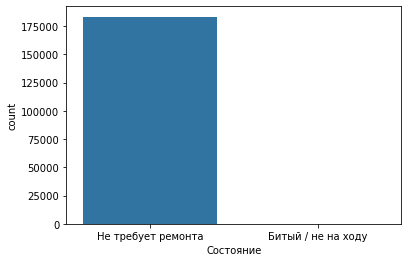

In [617]:
sns.countplot(x='Состояние', data=data_full)

Признак бинарный. Дополнительная обработка не требуется

In [618]:
bin_cols.append('Состояние')

## 18. Таможня
Признак одинаков для всех строк и не несет полезной информации. В модель не включаем.

## 19 equipment_dict
Данные этого поля дублируются в других полях датасета. Полезной информации не несет. В модель не включаем.

## 20. brand
марка автомобиля; тип данных - object

In [619]:
data_full['brand'].value_counts()

LADA (ВАЗ)       46758
Kia              17847
Toyota           16130
BMW              15307
Nissan           13279
Mercedes-Benz    11300
Renault          10374
Skoda             7304
Mitsubishi        7078
Audi              6429
VOLKSWAGEN        4404
NISSAN            4393
MERCEDES          4180
TOYOTA            3913
AUDI              3421
MITSUBISHI        2843
SKODA             2741
VOLVO             1463
ГАЗ               1227
HONDA             1150
INFINITI           871
LEXUS              834
Name: brand, dtype: int64

Имеются повторы. Обработаем данные

In [620]:
# приведем названия марок авто к нижнему регистру
data_full['brand'] = data_full['brand'].apply(lambda x: x.lower())

# заменим название mercedes-benz на mercedes
data_full['brand'] = data_full['brand'].apply(
    lambda x: x.replace('mercedes-benz', 'mercedes'))

Посмотрим результат

In [621]:
data_full['brand'].value_counts()

lada (ваз)    46758
toyota        20043
kia           17847
nissan        17672
mercedes      15480
bmw           15307
renault       10374
skoda         10045
mitsubishi     9921
audi           9850
volkswagen     4404
volvo          1463
газ            1227
honda          1150
infiniti        871
lexus           834
Name: brand, dtype: int64

Признак категориальный. Дополнительная обработка не требуется.

In [622]:
cat_cols.append('brand')

## 21. model_name
модель автомобиля; тип данных - object

In [623]:
data_full['model_name'].value_counts()

Granta           7084
Priora           5393
Rio              5259
2114             4322
Kalina           3771
                 ... 
SCEPTER_SEDAN       1
Clarus              1
VANEO               1
Xterra              1
Z1                  1
Name: model_name, Length: 982, dtype: int64

Обработаем данные

In [624]:
# приведем значения к нижнему регистру и удажим лишние пробелы
data_full['model_name'] = data_full['model_name'].apply(
    lambda x: x.lower().strip())
data_full['model_name'].value_counts()

granta             7084
priora             5393
rio                5259
octavia            4813
2114               4322
                   ... 
cavalier              1
fox                   1
lancer_ralliart       1
w114                  1
torneo                1
Name: model_name, Length: 821, dtype: int64

Число уникальных значений немного уменьшилось

Признак категориальный.

In [625]:
cat_cols.append('model_name')

## 22. name
полная информация о двигателе; тип данных - object

Информация в данном поле дублирует информацию в других полях. В модель не включаем.

## 23. sample_
признак включения в тестовый датасет

## 24. price

- стоимость автомобиля. тип данных - float

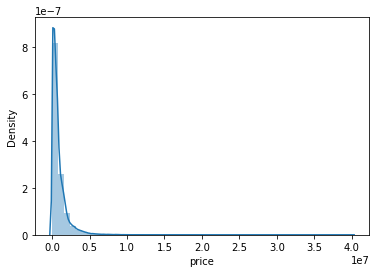

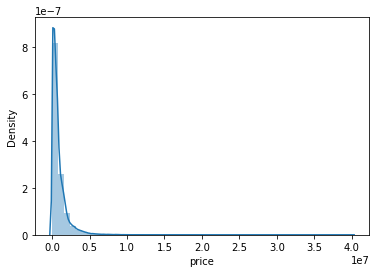

In [626]:
sns.distplot(data_full[data_full['sample_']==0]['price']).get_figure()

На распределении визуально заметны выбросы, но они не противоречат здравому смыслу, поэтому их можно оставить.

## Оставим в датасете только отобранные признаки

In [627]:
data_full = data_full[cat_cols + bin_cols + num_cols + ['price', 'sample_']]

# Обработка и анализ числовых признаков

Посмотрим на все числовые признаки.

In [628]:
data_full[data_full['sample_'] == 0][num_cols + ['price']]

,description_len,engineDisplacement,enginePower,mileage,productionDate,feature_mileage,tax,price
34686,155,3.0,218.0,215000,2005,0.001384,14170.0,545000.0
34687,538,4.1,326.0,117000,2008,0.002094,48900.0,1470000.0
34688,380,2.0,225.0,54500,2014,0.002569,16875.0,1830000.0
34689,425,2.7,250.0,200000,2004,0.001575,37500.0,390000.0
34690,419,3.0,239.0,225000,2010,0.000933,17925.0,990000.0
...,...,...,...,...,...,...,...,...
184798,126,1.6,106.0,2,2021,8.750000,2650.0,820000.0
184799,95,1.6,106.0,570,2021,0.030702,2650.0,812900.0
184800,438,1.6,106.0,4000,2021,0.004375,2650.0,835000.0
184801,460,1.6,106.0,100,2021,0.175000,2650.0,835000.0


Постороим матрицу корреляций числовых переменных друг с другом и с целевой переменной price.

<AxesSubplot:>

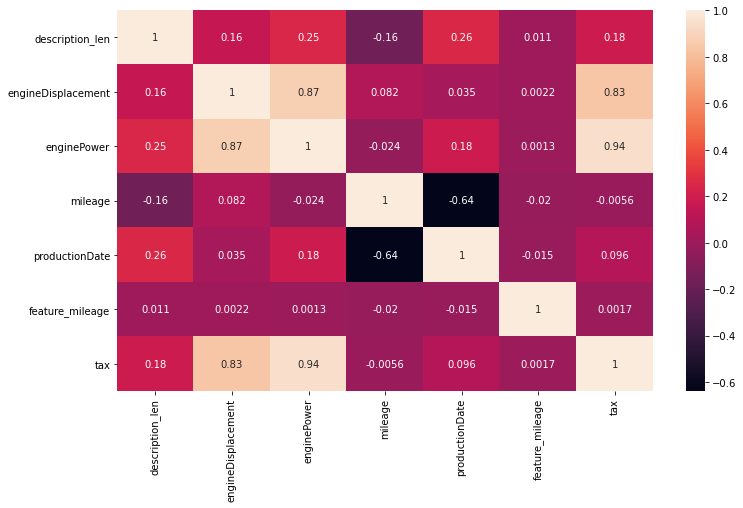

In [629]:
plt.figure(figsize=(12,7))
sns.heatmap(data_full[data_full['sample_'] == 0][num_cols].corr(), annot=True)

Здесь мы видим, что сильную корреляцию между собой имеют признаки engineDisplacement (объем двигателя) и enginePower (мощность двигателя) - 0.87, а также вновь созданный признак tax c engineDisplacement (объем двигателя) - 0,83 и enginePower (мощность двигателя) - 0.94. Поэтому удаляем один признак - engineDisplacement (объем двигателя).

In [630]:
data_full = data_full.drop(['engineDisplacement'], axis = 1)

Также удалим его из списка числовых переменных num_cols.

In [631]:
num_cols = num_cols[:1] + num_cols[2:]

Наблюдается достаточно высокая корреляция между productionDate (год производства автомобиля) и mileage (пробег автомобиля) - 0.66. Но здесь можно оставить оба признака.

Корреляция среди обучающих признаков с целевой переменной price (цена автомобиля) самая высокая у enginePower (мощность двигателя) - 0.65, но мы его оставляем.

Оценим значимость числовых переменных.

<AxesSubplot:>

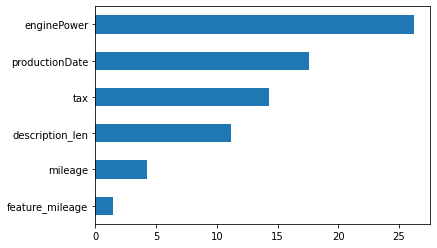

In [632]:
imp_num = Series(f_classif(data_full[num_cols][data_full['sample_'] == 0], data_full[data_full['sample_'] == 0]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из графика видим. что наиболее важный признак для предсказания - это enginePower (мощность двигателя), а наименее - feature_mileage.

# Обработка и анализ бинарных признаков
Преобразуем отобранные бинарные признаки

In [633]:
label_encoder = LabelEncoder()
for col in bin_cols:
    data_full[col] = label_encoder.fit_transform(data_full[col])

Проверим, что все корректно преобразовалось

In [634]:
data_full[bin_cols].head(5)

,description_is,real_photo,ПТС,Руль,Состояние
0,0,1,1,0,1
1,0,1,1,0,1
2,0,1,1,0,1
3,0,1,1,0,1
4,0,1,1,0,1


In [635]:
for i in bin_cols:
    display(data_full[i].value_counts())

0    183221
1        25
Name: description_is, dtype: int64

1    153667
0     29579
Name: real_photo, dtype: int64

1    159915
0     23331
Name: ПТС, dtype: int64

0    174678
1      8568
Name: Руль, dtype: int64

1    183243
0         3
Name: Состояние, dtype: int64

Посмотрим значимость

<AxesSubplot:>

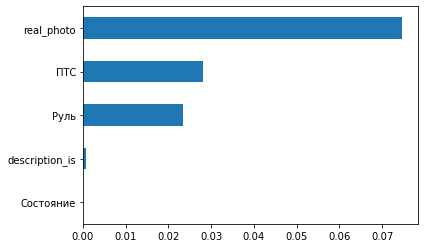

In [636]:
imp_cat = Series(mutual_info_classif(data_full[data_full.sample_ == 0][bin_cols], data_full[data_full.sample_ == 0]['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

На цену меньше всего влияет состояние, что противоречит здравому смыслу... Видимо сказывается несбалансированность этого признака, почти все объявления с одним значением. А самый больший вклад в цену вносит наличие реальной фотографии.

# Обработка и анализ категориальных признаков

In [637]:
#преобразование, значимость, выводы. Label encoding
data_full[cat_cols]

,bodyClass,color,fuelType,vehicleTransmission,Владельцы,Привод,brand,model_name
0,хэтчбек,синий,бензин,роботизированная,3 или более,передний,skoda,octavia
1,хэтчбек,чёрный,бензин,механическая,1 владелец,передний,skoda,octavia
2,хэтчбек,серый,бензин,роботизированная,1 владелец,передний,skoda,superb
3,хэтчбек,коричневый,бензин,автоматическая,1 владелец,передний,skoda,octavia
4,хэтчбек,белый,бензин,автоматическая,1 владелец,передний,skoda,octavia
...,...,...,...,...,...,...,...,...
184798,седан,белый,бензин,механическая,1 владелец,передний,lada (ваз),vesta
184799,седан,серый,бензин,механическая,1 владелец,передний,lada (ваз),vesta
184800,универсал,белый,бензин,механическая,1 владелец,передний,lada (ваз),largus
184801,седан,белый,бензин,механическая,1 владелец,передний,lada (ваз),vesta


Сделаем копию датасета

In [638]:
df = data_full.copy()

Произведем Label-encoding категориальных переменных

In [639]:
label_encoder = LabelEncoder()
for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])

Посмотрим значимость категориальных переменных

<AxesSubplot:>

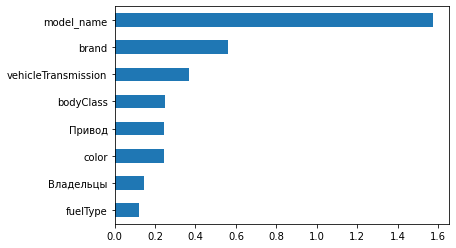

In [640]:
imp_cat = Series(mutual_info_classif(df[data_full.sample_ == 0][cat_cols], df[data_full.sample_ == 0]['price'],
                                     discrete_features =True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Как видно из графиков, наибольшее влияние на целевую переменную оказывают марка и модель автомобиля. Большое влияние модели автомобиля обусловлено относительно небольшим числом записей для каждой модели.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения цены по различным параметрам неразличимы

In [641]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            
for col in cat_cols:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки model_name


Так как число уникальных значений для поля model_name очень большое не включаем его в модель

In [642]:
cat_cols.remove('model_name')
data_full.drop(columns=['model_name'], inplace=True)

Создадим дамми переменные

In [643]:
data_full = pd.get_dummies(data_full, columns = cat_cols)

In [644]:
first_index_cat_cols = data_full.columns.to_list().index('sample_')+1
cat_cols = data_full.columns[first_index_cat_cols:].to_list()

Выгрузим данные в csv для дальнейшего обучения

In [645]:
data_full.to_csv(os.path.join(os.getcwd(),'input/data_car_eda.csv'), index = False)

Выгрузим названия колонок по типам

In [646]:
df_columns = pd.DataFrame()

for col in num_cols:
    new_row = {'column_type': 'num', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in bin_cols:
    new_row = {'column_type': 'bin', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)

for col in cat_cols:
    new_row = {'column_type': 'cat', 'column_name': col} 
    df_columns = df_columns.append(new_row, ignore_index=True)
    
df_columns.to_csv(os.path.join(os.getcwd(),'input/data_full_columns.csv'), index = False)

In [647]:
df = pd.read_csv(os.path.join(os.getcwd(),'input/data_full_columns.csv'))
data_full[df[df.column_type == 'cat'].column_name.values]

,bodyClass_other,bodyClass_внедорожник,bodyClass_вэн,bodyClass_кабрио,bodyClass_пикап,bodyClass_седан,bodyClass_универсал,bodyClass_хэтчбек,color_бежевый,color_белый,...,brand_lexus,brand_mercedes,brand_mitsubishi,brand_nissan,brand_renault,brand_skoda,brand_toyota,brand_volkswagen,brand_volvo,brand_газ
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184798,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
184799,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184800,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
184801,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [648]:
df

,column_name,column_type
0,description_len,num
1,enginePower,num
2,mileage,num
3,productionDate,num
4,feature_mileage,num
...,...,...
60,brand_skoda,cat
61,brand_toyota,cat
62,brand_volkswagen,cat
63,brand_volvo,cat


# Выводы
Спарсилось очень много дублей. Спарсенные данные не везде совпадают с тестовым датасетом, пришлось делать дополнительную обработку.
В данных очень много категориальных признаков. Некоторые признаки несбалансированы.

# Что можно улучшить:
1. Большое поле для feature engineering, много текста из которого можно вытащить доп информацию.  
2. Задействованы далеко не все из спарсенного, т.к. некоторые спарсенные данные не совпадают с тестовыми. Можно попытаться вытащить общую информацию из того что есть, или проанализировать и подкорректировать парсинг